# <p style="text-align:center;"> Language identification : a study of GlotLID-M model </p>

The objective of this Notebook is to study the model GlotLID-M, introduced by Karagan *et al.*, in "GlotLID: Lan-
guage Identification for Low-Resource Languages", in 2023. The notebook is constructed as follows : 
- A first part dedicated to the **construction of a simplified version of GlotLID-M**. The purpose is here to understand the different main mechanisms used in FastText, and to try a small implementation on a small dataset, with much less languages than in GlotLID-C. Follows a discussion on the results, and the obvious differences with the model
- A second part dedicated to **evaluation of the GlotLID-M through a new test set**. The dataset is statistically described, then we discuss the results and the possibility of overlapping with the training set of GlotLID-M.

In [192]:
# pip install numpy==1.26.4 (otherwise problem with fasttext from Facebook)

# First part 

import numpy as np
import pandas as pd
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import langcodes

# Second part 

import fasttext
from huggingface_hub import hf_hub_download

## 1 - Construction of a simplified version of GlotLID-M

The language identification model GlotLID-M mainly relies on the FastText architecture, proposed by the AI search team of Facebook, and on a huge databasis, GlotLID-C, which serves as a training corpus for the model. The aim here is to simplify the model FastText and the corpus, to exhibit the main idea of the model with simple tools.

### 1.1 - Model

In this subsection, we will try to construct a simplified version of the FastText architecture, proposed by Joulin *et al.* in 2017 in "Bag of Tricks for Efficient Text Classification". Of course, it won't be as developped as it was in the original paper, but the goal here is to propose a reachable model using our knowledge in NLP.

#### 1.1.1 - Preprocessing

Fist, the objectove is to present a proposition of representation of the different texts we have to classify. The choice of Joulin *et al.* was to represent texts through the average representation of its words, each word being first turned into a series of $n$-grams and then embedd into a vector space.

So, to represent the texts, we first have to represent words as a serie of $n$-grams. To understand how this representation works, we define a function `get_ngrams` which construct the representation of a word in a $n$-gram. 

In [193]:
def get_ngrams(word, min_n=3, max_n=6):
    '''
    Function that turn a word into a sequence of n-gram
    Input : - word : a string 
            - min_n : the smallest value of n for n-gram representation of a word (Default : 3)
            - max_n : the highest value of n for n-gram representation of a word (Default : 6)
    Output :- ngrams : a set object with the series of n-grams representing 'word', n going from min_n to max_n 
    '''
    word = f"<{word}>"
    ngrams = []
    for n in range(min_n, max_n + 1):
        for i in range(len(word) - n + 1):
            ngrams.append(word[i:i+n])
    return ngrams


A small example to understand how the representation in $n$-grams works, for only one value of $n$.

In [194]:
get_ngrams("bienvenue", min_n=3, max_n=3)

['<bi', 'bie', 'ien', 'env', 'nve', 'ven', 'enu', 'nue', 'ue>']

Then, when the same example with the representation using several values of $n$. 

In [195]:
get_ngrams("bienvenue", min_n=3, max_n=6)

['<bi',
 'bie',
 'ien',
 'env',
 'nve',
 'ven',
 'enu',
 'nue',
 'ue>',
 '<bie',
 'bien',
 'ienv',
 'enve',
 'nven',
 'venu',
 'enue',
 'nue>',
 '<bien',
 'bienv',
 'ienve',
 'enven',
 'nvenu',
 'venue',
 'enue>',
 '<bienv',
 'bienve',
 'ienven',
 'envenu',
 'nvenue',
 'venue>']

**Remark** : the use of several values of $n$ in the $n$-grams representation of a word helps catching different levels of granluarity of representation of a word, and helps catching many type of structure in the representation of a word. However, this gives very long vectors to handle for the algorithm, and as a consequence it has been decided to keep only one value of $n$ - which is $n=4$.

Now, we want to construct a class which helps building the representation of a text using the $n$-grams representation of its words, before constructing an embedding of the text starting from it. 

In [196]:
class FastTextClassifierPreprocessor:
    def __init__(self, ngram_range=(4, 4), min_count=1):
        self.ngram_range = ngram_range  # Tuple indicating the min and max n-gram lengths to extract
        self.min_count = min_count      # Minimum frequency for an n-gram to be considered
        self.word_counts = Counter()    # Will store word counts if needed (currently unused)
        self.ngram2idx = {}             # Dictionary mapping n-grams to unique integer IDs
        self.label2idx = {}             # Dictionary mapping labels to unique integer IDs
        self.idx2label = {}             # Reverse mapping from IDs to original labels

    def tokenize(self, text):
        '''
        Function that divides a text into a list of words, getting rid of the upper cases
        Input :  - text : a string 
        Output : - a list
        '''
        return re.findall(r'\b\w+\b', text.lower())

    def get_ngrams(self, word):
        '''
        Function that turns a word into a sequence of n-grams
        Input : - word : a string 
        Output :- ngrams : a list object with the series of n-grams representing 'word', 
                            n taking its values in self.ngram_range
        '''
        word = f"<{word}>"  # Add boundary markers to preserve word start/end
        ngrams = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            for i in range(len(word) - n + 1):
                ngrams.append(word[i:i+n])
        return ngrams

    def text_to_ngrams(self, text):
        '''
        Function that converts a text into the list of all the representations of its words
        Input :  - text : a string 
        Output : - ngrams : a list object with the series of n-grams representing all the words of 'text', 
                            n taking its values in self.ngram_range
        '''
        tokens = self.tokenize(text)
        all_ngrams = []
        for token in tokens:
            all_ngrams.extend(self.get_ngrams(token))
        return all_ngrams

    def fit(self, texts, labels):
        '''
        Function that learns the vocabulary of n-grams and maps labels to indices
        Inputs : - texts : a list of strings (training documents)
                 - labels : a list of labels associated with each text
        Output : None (updates the object's state with learned mappings)
        '''
        ngram_counter = Counter()  # Will store frequency of each n-gram
        label_set = set(labels)    # Extract unique labels from the dataset

        for text in texts:
            ngram_counter.update(self.text_to_ngrams(text))  # Count all n-grams in each text

        # Filter n-grams based on frequency and assign unique indices
        self.ngram2idx = {
            ngram: i for i, (ngram, count) in enumerate(ngram_counter.items())
            if count >= self.min_count  # We only keep n-grams that appear at least `min_count` times
        }

        # Create mappings between labels and their indices
        self.label2idx = {label: i for i, label in enumerate(sorted(label_set))}
        self.idx2label = {i: label for label, i in self.label2idx.items()}

    def transform(self, texts, labels=None):
        '''
        Function that converts raw texts into sequences of n-gram indices, and labels into label indices
        Inputs : - texts : a list of strings to be transformed
                 - labels (optional) : a list of labels corresponding to each text
        Outputs: - X : a list of lists, each containing indices of n-grams found in a text
                 - y (optional) : an array of label indices (if labels are provided)
        '''
        X = []  # List of transformed texts (as n-gram index sequences)
        y = []  # List of corresponding label indices

        for text in texts:
            ngrams = self.text_to_ngrams(text)  # Extract n-grams from the text
            ngram_ids = [self.ngram2idx[ng] for ng in ngrams if ng in self.ngram2idx]  # Map to indices
            X.append(ngram_ids)

        if labels:
            y = [self.label2idx[label] for label in labels]  # Map labels to indices
            return X, np.array(y)

        return X


#### 1.1.2 - FastText Classifier Model

Now that there is a class which can turn a text into a vector, we can implement the real embedding and classification class, with is FastText-ish architecture. The concept is to embed the vectors in a small vector space, and then to classify these vectors thanks to a linear classification layer.

In [197]:
class FastTextClassifier:
    def __init__(self, num_ngrams, num_classes, embedding_dim=100, lr=0.05):
        '''
        Constructor for the FastTextClassifier model.
        Inputs : - num_ngrams : total number of unique n-grams (size of vocabulary)
                 - num_classes : total number of output classes
                 - embedding_dim : size of the embedding vectors
                 - lr : learning rate for training
        '''
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.lr = lr

        # Initialize word n-gram embeddings randomly with small values
        self.embeddings = np.random.randn(num_ngrams, embedding_dim).astype(np.float32) * 0.01
        # Initialize linear classifier weights and biases
        self.linear_weights = np.random.randn(num_classes, embedding_dim).astype(np.float32) * 0.01
        self.linear_bias = np.zeros(num_classes)

    def softmax(self, x):
        '''
        Function that computes the softmax of a vector (for probability distribution)
        Input :  - x : a numpy array of logits
        Output : - probabilities after applying softmax
        '''
        e_x = np.exp(x - np.max(x))  # for numerical stability
        return e_x / e_x.sum()

    def forward(self, ngram_ids):
        '''
        Function that performs a forward pass to compute class probabilities
        Input :  - ngram_ids : list of indices representing the n-grams of a text
        Outputs: - probs : predicted class probabilities
                 - doc_vec : average embedding vector representing the text
        '''
        if not ngram_ids:
            return np.zeros(self.num_classes), np.zeros(self.embedding_dim)

        vecs = self.embeddings[ngram_ids]          # Lookup embeddings for n-grams
        doc_vec = np.mean(vecs, axis=0)            # Average to get document vector
        logits = self.linear_weights @ doc_vec + self.linear_bias  # Linear layer
        probs = self.softmax(logits)               # Convert logits to probabilities
        return probs, doc_vec

    def train_step(self, ngram_ids, label_idx):
        '''
        Function that performs one step of gradient descent for a single example
        Inputs : - ngram_ids : list of indices for n-grams in the input text
                 - label_idx : index of the true class label
        Output : - loss : cross-entropy loss for the current training example
        '''
        probs, doc_vec = self.forward(ngram_ids)   # Forward pass
        loss = -np.log(probs[label_idx] + 1e-9)    # Compute negative log likelihood loss

        # Compute gradients of loss w.r.t. logits
        dL_dlogits = probs
        dL_dlogits[label_idx] -= 1

        # Update the linear layer weights and biases
        self.linear_weights -= self.lr * np.outer(dL_dlogits, doc_vec)
        self.linear_bias -= self.lr * dL_dlogits

        # Backpropagate gradient to embeddings
        grad_doc_vec = self.linear_weights.T @ dL_dlogits
        for idx in ngram_ids:
            self.embeddings[idx] -= self.lr * grad_doc_vec / len(ngram_ids)  # Distribute gradient evenly

        return loss

    def predict(self, ngram_ids):
        '''
        Function that returns the predicted class index for a given input
        Input :  - ngram_ids : list of indices representing the n-grams of a text
        Output : - class index with the highest predicted probability
        '''
        probs, _ = self.forward(ngram_ids)
        return np.argmax(probs)

    def predict_proba(self, ngram_ids):
        '''
        Function that returns the predicted class probabilities for a given input
        Input :  - ngram_ids : list of indices representing the n-grams of a text
        Output : - probs : list of probabilities for each class
        '''
        probs, _ = self.forward(ngram_ids)
        return probs


#### 1.1.3 - Training Loop

Now that the model is available, here is the code to train the model on available datas (texts as $X$ and languages as labels $Y$).

In [198]:
def train_classifier(texts, labels, epochs=5, embedding_dim=100, lr=0.05):
    '''
    Function that trains a FastText-style classifier on labeled text data
    Inputs : - texts : a list of input strings (documents)
             - labels : a list of class labels corresponding to each text
             - epochs : number of passes through the dataset for training
             - embedding_dim : dimensionality of the embedding vectors
             - lr : learning rate for the optimizer
    Outputs: - model : the trained FastTextClassifier instance
             - preproc : the fitted FastTextClassifierPreprocessor instance
    '''

    # Create and fit the preprocessor to build vocabulary and label mappings
    preproc = FastTextClassifierPreprocessor()
    preproc.fit(texts, labels)

    # Transform texts and labels into numerical format (n-gram indices and label indices)
    X, y = preproc.transform(texts, labels)

    # Initialize the FastTextClassifier model with the size of the vocabulary and number of classes
    model = FastTextClassifier(
        num_ngrams=len(preproc.ngram2idx),
        num_classes=len(preproc.label2idx),
        embedding_dim=embedding_dim,
        lr=lr
    )

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        total_loss = 0  # Accumulate loss to monitor training progress
        for i in range(len(X)):
            loss = model.train_step(X[i], y[i])  # Perform a single training step
            total_loss += loss
        print(f"Epoch {epoch + 1} Loss: {total_loss:.4f}")  # Report average loss per epoch

    # Return the trained model and the preprocessor (useful for inference)
    return model, preproc


#### 1.1.4 - Inference

Once the model has been trained, it can be used to make inference on test data using the following code.

In [199]:
def predict_text(model, preproc, text):
    '''
    Function that predicts the class label of a single text input
    Inputs : - model : a trained FastTextClassifier instance
             - preproc : the corresponding fitted FastTextClassifierPreprocessor
             - text : a string (the input text to classify)
    Output : - predicted label (as a string)
    '''
    ngram_ids = preproc.transform([text])[0]       # Convert text into list of n-gram indices
    label_idx = model.predict(ngram_ids)           # Predict the label index using the model
    return preproc.idx2label[label_idx]            # Convert index back to original label string


#### 1.1.5 - Training

##### Choice of a dataset

Now we get back to the problem of language identification. Now that we have the architecture of the model, we need to build a training dataset for the task of language identification. In order to train our model, we use a small subpart of the GlotLID-C corpus, which is to know the Wili_2018, databasis, which consists in 235 000 Wikipedia paragraphs of 235 languages. The dataset is balanced and a train-test split is provided. 117 500 lines of text each for train and test data. We will first try to statistically analyse this dataset.

To start, here is a dictionnary that converts the label of the dataset into the ISO 639-3 code of the associate language. The name of the language can then be given thanks to the library `langcodes`.

In [200]:
dico = {'0': 'cdo','1': 'glk', '2': 'jam', '3': 'lug', '4': 'san', '5': 'rue', '6': 'wol', '7': 'new', '8': 'mwl', '9': 'bre', '10': 'ara', 
        '11': 'hye', '12': 'xmf', '13': 'ext', '14': 'cor', '15': 'yor', '16': 'div', '17': 'asm', '18': 'lat', '19': 'cym', '20': 'hif', 
        '21': 'ace', '22': 'kbd', '23': 'tgk', '24': 'rus', '25': 'nso', '26': 'mya', '27': 'msa', '28': 'ava', '29': 'cbk', '30': 'urd', 
        '31': 'deu', '32': 'swa','33': 'pus','34': 'bxr','35': 'udm','36': 'csb','37': 'yid','38': 'vro','39': 'por','40': 'pdc',
        '41': 'eng','42': 'tha','43': 'hat','44': 'lmo','45': 'pag','46': 'jav','47': 'chv','48': 'nan','49': 'sco','50': 'kat',
        '51': 'bho','52': 'bos','53': 'kok','54': 'oss','55': 'mri','56': 'fry','57': 'cat','58': 'azb','59': 'kin','60': 'hin',
        '61': 'sna','62': 'dan','63': 'egl','64': 'mkd','65': 'ron','66': 'bul','67': 'hrv','68': 'som','69': 'pam','70': 'nav',
        '71': 'ksh','72': 'nci','73': 'khm','74': 'sgs','75': 'srn','76': 'bar','77': 'cos','78': 'ckb','79': 'pfl','80': 'arz',
        '81': 'roa-tara','82': 'fra','83': 'mai','84': 'zh-yue','85': 'guj','86': 'fin','87': 'kir','88': 'vol','89': 'hau','90': 'afr',
        '91': 'uig','92': 'lao','93': 'swe','94': 'slv','95': 'kor','96': 'szl','97': 'srp','98': 'dty','99': 'nrm','100': 'dsb',
        '101': 'ind','102': 'wln','103': 'pnb','104': 'ukr','105': 'bpy','106': 'vie','107': 'tur','108': 'aym','109': 'lit','110': 'zea',
        '111': 'pol','112': 'est','113': 'scn','114': 'vls','115': 'stq','116': 'gag','117': 'grn','118': 'kaz','119': 'ben','120': 'pcd',
        '121': 'bjn','122': 'krc','123': 'amh', '124': 'diq','125': 'ltz','126': 'ita','127': 'kab','128': 'bel','129': 'ang','130': 'mhr',
        '131': 'che', '132': 'koi','133': 'glv','134': 'ido','135': 'fao','136': 'bak','137': 'isl','138': 'bcl','139': 'tet','140': 'jpn',
        '141': 'kur','142': 'map-bms','143': 'tyv','144': 'olo','145': 'arg','146': 'ori','147': 'lim','148': 'tel','149': 'lin','150': 'roh',
        '151': 'sqi','152': 'xho','153': 'mlg','154': 'fas','155': 'hbs','156': 'tam','157': 'aze','158': 'lad','159': 'nob','160': 'sin',
        '161': 'gla','162': 'nap','163': 'snd','164': 'ast','165': 'mal','166': 'mdf','167': 'tsn','168': 'nds','169': 'tgl','170': 'nno',
        '171': 'sun','172': 'lzh','173': 'jbo','174': 'crh','175': 'pap','176': 'oci','177': 'hak','178': 'uzb','179': 'zho','180': 'hsb',
        '181': 'sme','182': 'mlt','183': 'vep','184': 'lez','185': 'nld','186': 'nds-nl','187': 'mrj','188': 'spa','189': 'ceb','190': 'ina',
        '191': 'heb','192': 'hun','193': 'que','194': 'kaa','195': 'mar','196': 'vec','197': 'frp','198': 'ell','199': 'sah','200': 'eus',
        '201': 'ces','202': 'slk','203': 'chr','204': 'lij','205': 'nep','206': 'srd','207': 'ilo','208': 'be-tarask','209': 'bod','210': 'orm',
        '211': 'war','212': 'glg','213': 'mon','214': 'gle','215': 'min','216': 'ibo','217': 'ile','218': 'epo','219': 'lav','220': 'lrc','221': 'als',
        '222': 'mzn','223': 'rup','224': 'fur','225': 'tat','226': 'myv','227': 'pan','228': 'ton','229': 'kom','230': 'wuu','231': 'tcy',
        '232': 'tuk','233': 'kan','234': 'ltg'}

In [201]:
splits = {'train': 'WiLI-2018 dataset/train-00000-of-00001.parquet', 'test': 'WiLI-2018 dataset/test-00000-of-00001.parquet'}
wili_2018_train = pd.read_parquet("hf://datasets/MartinThoma/wili_2018/" + splits["train"])
wili_2018_train

,sentence,label
0,Klement Gottwaldi surnukeha palsameeriti ning ...,112
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",93
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,83
3,"Après lo cort periòde d'establiment a Basilèa,...",176
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,42
...,...,...
117495,Nekoliko prašćića je rođeno na farmi Arableovi...,52
117496,Tahiti of Otaheite is 'n eilandj in 't zuje va...,147
117497,同年，太后崩。絳侯周勃、陳平諸臣共謀誅呂。朱虛侯章已殺呂產，文帝使人持節勞章。朱虛侯欲奪節信...,172
117498,I det mindste opnåede Venedig den 18. april 14...,62


##### Description of the data

The dataset is shortly described statistically. We first describe the proportion of each language of the dataset.

C:\Users\capot\AppData\Local\Temp\ipykernel_5960\1019824544.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='viridis')


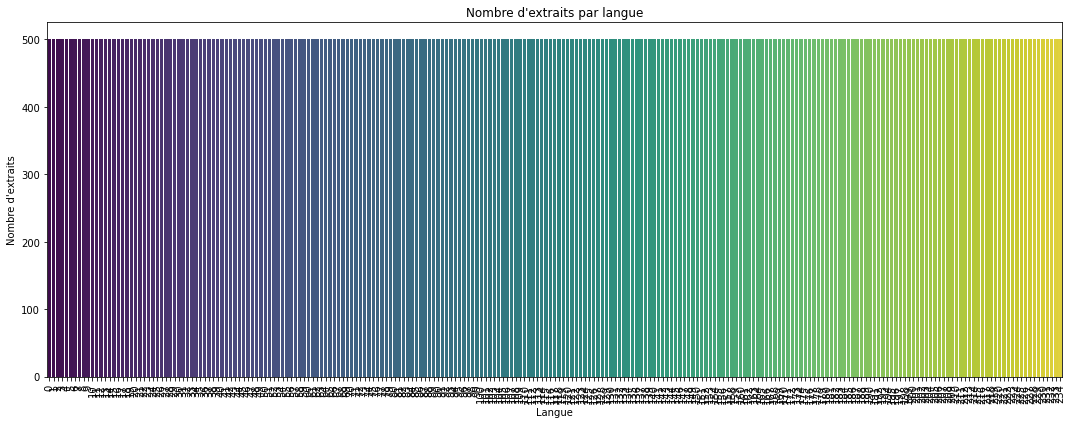

In [202]:
lang_counts = wili_2018_train['label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title("Nombre d'extraits par langue")
plt.xlabel("Langue")
plt.ylabel("Nombre d'extraits")
plt.tight_layout()
plt.show()

As we can see, the repartition of the languages is uniform for all the available languages, with 500 sentences for each of the 235 languages available. 

Now, we can check for descriptive statistics regarding the text length of elements in the dataset.

In [203]:
wili_2018_train['text_length_chars'] = wili_2018_train['sentence'].apply(len)
wili_2018_train['text_length_words'] = wili_2018_train['sentence'].apply(lambda x: len(x.split()))

# Descriptive statistics
print(wili_2018_train[['text_length_chars', 'text_length_words']].describe())

       text_length_chars  text_length_words
count      117500.000000      117500.000000
mean          369.214689          54.550809
std           457.338680          52.982298
min           140.000000           1.000000
25%           189.000000          28.000000
50%           271.000000          41.000000
75%           432.000000          65.000000
max         40578.000000        4507.000000


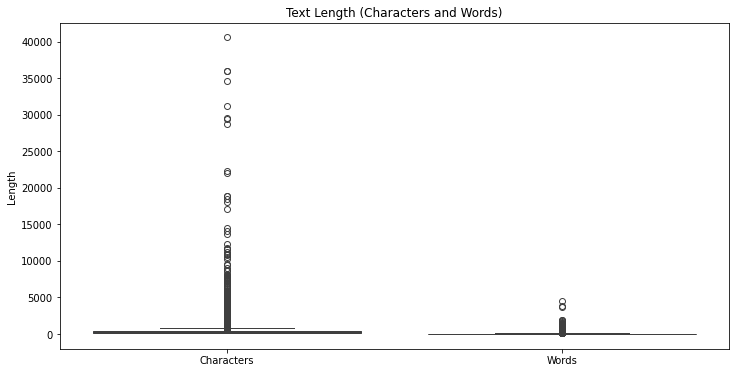

In [204]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=wili_2018_train[['text_length_chars', 'text_length_words']])
plt.title("Text Length (Characters and Words)")
plt.ylabel("Length")
plt.xticks([0, 1], ['Characters', 'Words'])
plt.show()


6. Type-Token Ratio (lexical diversity)

count    117500.000000
mean          0.854955
std           0.105952
min           0.174721
25%           0.788462
50%           0.869565
75%           0.937500
max           1.000000
Name: type_token_ratio, dtype: float64


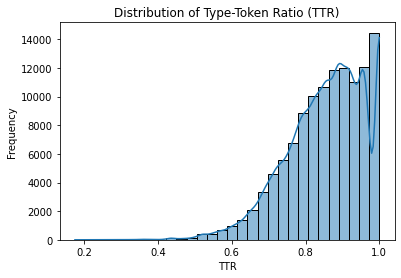

In [205]:
def type_token_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

wili_2018_train['type_token_ratio'] = wili_2018_train['sentence'].apply(type_token_ratio)

print(wili_2018_train['type_token_ratio'].describe())

# Distribution plot
plt.figure()
sns.histplot(wili_2018_train['type_token_ratio'], bins=30, kde=True)
plt.title("Distribution of Type-Token Ratio (TTR)")
plt.xlabel("TTR")
plt.ylabel("Frequency")
plt.show()

 7. Characters analysis

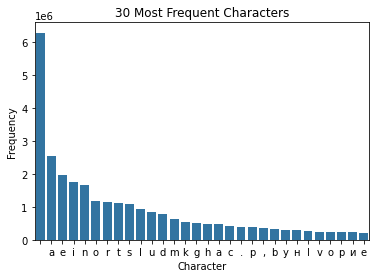

In [206]:
# Count all characters
all_chars = Counter("".join(wili_2018_train['sentence']))
most_common_chars = all_chars.most_common(30)

# Plot
chars, counts = zip(*most_common_chars)
plt.figure()
sns.barplot(x=list(chars), y=list(counts))
plt.title("30 Most Frequent Characters")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()

### 1.2 - Evaluation of the model

#### 1.2.1 - Inference

In [207]:
texts = wili_2018_train["sentence"].values.tolist()
labels = wili_2018_train["label"].values.tolist()

In [ ]:
# Code to train the model (about 5 minutes per epoch, so 100 minutes in total)

#model, preproc = train_classifier(texts, labels, epochs=20)

In [209]:
# Save model parameters in the file 'model_parameters.npz'

#np.savez_compressed(
#    'model_parameters.npz',
#    embeddings=model.embeddings,
#    linear_weights=model.linear_weights,
#    linear_bias=model.linear_bias
#)

In [210]:
# If one wants to load the model without having to re-train

preproc = FastTextClassifierPreprocessor()
preproc.fit(texts, labels)

# Transform texts and labels into numerical format (n-gram indices and label indices)
#X, y = preproc.transform(texts_test, labels_test)

data = np.load('model_parameters.npz', mmap_mode='r')

model = FastTextClassifier(
        num_ngrams=len(preproc.ngram2idx),
        num_classes=len(preproc.label2idx),
    )

model.embeddings = data['embeddings']
model.linear_weights = data['linear_weights']
model.linear_bias = data['linear_bias']

Now that we get the model, it's time to see what its predictions look like. Let's begin with a simple sentence in French, and see if the model can identify the language.

In [211]:
prediction_1 = predict_text(model, preproc, "Les hommes sont égaux")
prediction_1

99

We now print the name of the corresponding language.

In [245]:
code_1 = dico[str(prediction_1)]
langcodes.get(code_1).language_name()

'Narom'

Here are some examples inthe dataset of sentences using this in the training dataset language.

In [213]:
wili_2018_train.loc[wili_2018_train['label'] == prediction_1]

,sentence,label,text_length_chars,text_length_words,type_token_ratio
545,En 1925 la ville dévînt la ville auve la pus g...,99,171,30,0.900000
937,Coume o se madyit acaunt le roué Louis VII dé ...,99,534,98,0.775510
1071,Eune montangne dé feu ou montangne brûlante es...,99,163,27,0.851852
2012,"Couotaunches, la capitale du Cotentin, avait e...",99,293,51,0.901961
2024,Y'a des diffethentes couôteunmes l'travèrs du ...,99,362,56,0.785714
...,...,...,...,...,...
116365,"Dé ch'té mannyire, la Normaundie 'tait eun fra...",99,170,26,0.923077
116530,"Lé nom mèrcat veint d'l'Afrikaans meerkat, v'l...",99,393,63,0.809524
117103,Quand l'tourisme ès grèves dévînt populaithe a...,99,371,59,0.915254
117153,Lé Cap (en Angliais: Cape Town; en Afrikaans: ...,99,236,42,0.904762


The language indeed seems like French, but the prediction is incorrect. We now make the same for an other example for another sentence, in English.

In [214]:
prediction_2 = predict_text(model, preproc, "All you need is a kiss")
prediction_2

120

In [215]:
code_2 = dico[str(prediction_2)]
langcodes.get(code_2).language_name()

'Picard'

In [216]:
wili_2018_train.loc[wili_2018_train['label'] == prediction_2]

,sentence,label,text_length_chars,text_length_words,type_token_ratio
12,Espace dédié à la présentation de l'ensemble d...,120,162,26,0.846154
204,Chinmetière : édseur ch' meunumint funéraire à...,120,151,27,0.962963
1043,"Ch' comte Xavier Ugène d' Diesbach Belleroche,...",120,221,34,0.911765
1114,Where can I find more information and ask ques...,120,186,32,0.875000
1214,"Jean-Loup Jacques Marie Chrétien, né à La Roch...",120,341,55,0.836364
...,...,...,...,...,...
116748,Fouquereul (in frinsé: Fouquereuil) ch'est ène...,120,146,19,0.947368
116950,Prudefin o Prédefonye (in frinsé: Prédefin) ch...,120,156,21,0.952381
117032,"Kaddour-Jean Derrar, ch' mayeu, l'est né au 25...",120,188,33,0.969697
117087,Samé (in frinsé: Samer) (in flamind: Sint-Wulm...,120,200,28,0.928571


The purpose now is to quantify the performances of the model on a large number of examples. 

#### 1.2.2 - Metrics

In order to quantify the performances of the model, we have first to choose a metric. In classification, classic metrics are accuracy, precision, recall and F1 score.

In the paper, they use the F1 score and the false positive rate, defined this way - for each class (ie each language):

$$\text{F1 score} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \quad \text{and} \quad \text{FP-rate} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}$$
where 
$$\text{Precision}  = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \quad \text{and} \quad \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$ 
In order to make our results comparable to the ones of the paper, we decide to use the same metrics. The following code cell we use is the implementation of metrics proposed on the GitHub repo of the GlotLID-M model.

**Remark** : In the paper, they choose not to use the accurary ratio because the classes are highly imbalanced. Here, because our dataset use way less languages than GlotLID-M and because the number of examples in each class is equal (see below), we could have use the accuracy ratio too.

**Remark** : Because of the large number of classes, a confusion matrix wouldn't be really helpful here, because we wouldn't be able to read it.

In [217]:
def compute_f1_false_positive(data, true_label_name, predicted_label_name):
    # Assuming the column with name 'true_label_name' contains true labels,
    # and the column with name 'predicted_label_name' contains predicted labels
    iso_codes = list(data[true_label_name])
    predicted_iso_codes = list(data[predicted_label_name])
    
    
    labels = list(set(iso_codes + predicted_iso_codes))
    label_to_index = {label: index for index, label in enumerate(labels)}
    iso_codes = [label_to_index[label] for label in iso_codes]
    predicted_iso_codes = [label_to_index[label] for label in predicted_iso_codes]
    
    
    # Compute F1 scores per label
    f1_scores = f1_score(iso_codes, predicted_iso_codes, average=None)
    precision_scores = precision_score(iso_codes, predicted_iso_codes, average=None)
    recall_scores = recall_score(iso_codes, predicted_iso_codes, average=None)    
    
    
    # Compute False Positive Rate per label
    confusion_mat = confusion_matrix(iso_codes, predicted_iso_codes)
    
    FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  
    FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
    TP = np.diag(confusion_mat)
    TN = confusion_mat.sum() - (FP + FN + TP)


    fp_rate = FP / (FP + TN)
    
    # Handle division by zero by setting FPR to 0 where actual_negatives is 0
    fp_rate = np.nan_to_num(fp_rate, nan=0.0)
    
    
    # Create DataFrame to store results
    result_df = pd.DataFrame({
        'label': labels,
        'f1_score': f1_scores,
        'precision_score': precision_scores,
        'recall_score': recall_scores,
        'false_positive_rate': fp_rate
    })
    
    return result_df

#### 1.2.3 - Test

Now that we have our metric, it's time to evaluate the performances of the model on the evaluation dataset of WiLI-2018.

In [218]:
wili_2018_test = pd.read_parquet("hf://datasets/MartinThoma/wili_2018/" + splits["test"])
wili_2018_test

,sentence,label
0,Ne l fin de l seclo XIX l Japon era inda çconh...,8
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185
2,"ГIурусаз батальонал, гьоркьор гIарадабиги лъун...",28
3,ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...,231
4,Halukum adalah kelenjar tiroid nang menonjol d...,121
...,...,...
117495,"Wakati wa mimba,homa ya Q ni vigumu kutibu kwa...",32
117496,گیلون یک ته تاریخی منطقه‌ سفیدرود دلتای طرف ای...,1
117497,តាម​រយៈ​ការ​ចិញ្ចឹម​មនោសញ្ចេតនា​ជាតិនិយម​បែប​ន...,73
117498,روس اک وفاق اے تے 1 مارچ 2008ء توں اسدیاں 83 و...,103


For each sentence of this dataset, we add a column for the predicted language.

In [219]:
name_language=[]
label_pred=[]
for i in range(len(wili_2018_test)) : 
    # For an easier exploitation of the results, we add the name of the languages in the dataset
    pred = predict_text(model, preproc, wili_2018_test.iloc[i]["sentence"])
    code = dico[str(pred)]
    name_language.append(langcodes.get(code).language_name()) 
    label_pred.append(pred)
wili_2018_test["label_pred"] = label_pred
wili_2018_test["language"] = name_language

In [220]:
wili_2018_test

,sentence,label,label_pred,language
0,Ne l fin de l seclo XIX l Japon era inda çconh...,8,8,Mirandese
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,185,185,Dutch
2,"ГIурусаз батальонал, гьоркьор гIарадабиги лъун...",28,28,Avaric
3,ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...,231,231,Tulu
4,Halukum adalah kelenjar tiroid nang menonjol d...,121,121,Banjar
...,...,...,...,...
117495,"Wakati wa mimba,homa ya Q ni vigumu kutibu kwa...",32,32,Swahili
117496,گیلون یک ته تاریخی منطقه‌ سفیدرود دلتای طرف ای...,1,1,Gilaki
117497,តាម​រយៈ​ការ​ចិញ្ចឹម​មនោសញ្ចេតនា​ជាតិនិយម​បែប​ន...,73,73,Khmer
117498,روس اک وفاق اے تے 1 مارچ 2008ء توں اسدیاں 83 و...,103,103,Western Panjabi


Using this new dataset, we compute the values of the metrics for the different classes.

In [221]:
result_df = compute_f1_false_positive(wili_2018_test, 'label', 'label_pred')
new_name_language=[]
for i in range(len(result_df)) : 
    # For an easier exploitation of the results, we add the name of the languages in the dataset
    code = dico[str(wili_2018_test.iloc[i]["label"])]
    new_name_language.append(langcodes.get(code).language_name()) 
result_df["language"] = new_name_language
result_df

,label,f1_score,precision_score,recall_score,false_positive_rate,language
0,0,0.865508,0.797639,0.946,0.001026,Mirandese
1,1,0.928210,0.938650,0.918,0.000256,Dutch
2,2,0.988945,0.993939,0.984,0.000026,Avaric
3,3,0.985830,0.997951,0.974,0.000009,Tulu
4,4,0.960080,0.958167,0.962,0.000179,Banjar
...,...,...,...,...,...,...
230,230,0.095952,0.191617,0.064,0.001154,Tatar
231,231,0.970796,0.977688,0.964,0.000094,Bishnupriya
232,232,0.984833,0.995910,0.974,0.000017,Arabic
233,233,0.969880,0.973790,0.966,0.000111,Urdu


In [ ]:
result_df.loc["languages"]

label                                  189
f1_score                          0.997003
precision_score                   0.996008
recall_score                         0.998
false_positive_rate               0.000017
language               Pennsylvania German
Name: 189, dtype: object

In [222]:
sorted_result_df = result_df.sort_values(by=['f1_score'])
sorted_result_df.head(5)

,label,f1_score,precision_score,recall_score,false_positive_rate,language
230,230,0.095952,0.191617,0.064,0.001154,Tatar
84,84,0.131343,0.258824,0.088,0.001077,Oromo
179,179,0.259209,0.407725,0.190,0.001179,Mingrelian
155,155,0.370909,0.470769,0.306,0.001470,Pennsylvania German
67,67,0.423445,0.526786,0.354,0.001359,Sanskrit


In [223]:
sorted_result_df.tail(5)

,label,f1_score,precision_score,recall_score,false_positive_rate,language
189,189,0.997003,0.996008,0.998,0.000017,Pennsylvania German
215,215,0.998999,1.000000,0.998,0.000000,Ossetic
70,70,0.998999,1.000000,0.998,0.000000,Irish
22,22,0.998999,1.000000,0.998,0.000000,Korean
153,153,0.998999,1.000000,0.998,0.000000,Swahili


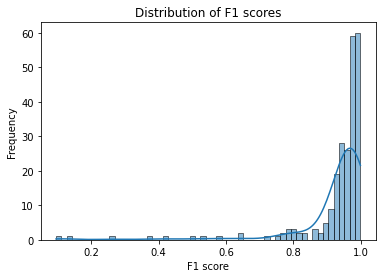

In [224]:
# Distribution plot
plt.figure()
sns.histplot(sorted_result_df['f1_score'], kde=True)
plt.title("Distribution of F1 scores")
plt.xlabel("F1 score")
plt.ylabel("Frequency")
plt.show()

## 2 - Evaluation of the GlotLID-M through a new test set

We now want to import the real GlotLID-M model and try to figure out its performances on a test set. We first try to get the same results of the paper, using the same test datasets. We would then like to compare the performances 

In [225]:
# download model and get the model path
# cache_dir is the path to the folder where the downloaded model will be stored/cached.
model_path = hf_hub_download(repo_id="cis-lmu/glotlid", filename="model_v1.bin", cache_dir=None)
print("model path:", model_path)

# load the model
model = fasttext.load_model(model_path)

model path: C:\Users\capot\.cache\huggingface\hub\models--cis-lmu--glotlid\snapshots\74cb50b709c9eefe0f790030c6c95c461b4e3b77\model_v1.bin


**Remark** : We aim at testing the model as it is presented in the paper, that's why we load `model_v1.bin`, whereas there exists two more recent version of the model available online. 

### 2.1 - UDHR

In [226]:
udhr = pd.read_csv("hf://datasets/cis-lmu/udhr-lid/udhr-lid.csv")

In [227]:
udhr

,id,sentence,iso639-3,iso15924,language
0,tir_Ethi,ሕድሕድ ኦብ ስራሕ ዝርከብ ሰብ ሰብኦዊ ክብሩን ክብሪ ቤተሰቡን ዝሕለወሉ ...,tir,Ethi,Tigrinya
1,tir_Ethi,ሕድሕድ ሰብ ከቢድ ስቓይ ዘውርድ፣ ጭካነ ዝመልኦ፣ ኢሰብኦዊ ወይ ሰብኦዊ ...,tir,Ethi,Tigrinya
2,tir_Ethi,ሕድሕድ ሰብ መሰሉን ግቡእን፣ ከምኡ’ውን ንዝቐርበሉ ዝኾነ ይኹን ገበናዊ ...,tir,Ethi,Tigrinya
3,tir_Ethi,ንዓቕመ ኦዳምን ሄዋንን ዝበፅሑ ደቂ ተባዕትዮን ደቂ ኦንስትዮን ዘርኢ፣ ዜ...,tir,Ethi,Tigrinya
4,tir_Ethi,ሕድሕድ ሰብ ብማሕበር ንኽውደብ ኦይግደድን፡፡,tir,Ethi,Tigrinya
...,...,...,...,...,...
27752,hil_Latn,Ang tagsa tagsa may bug-os nga pag-alalangay n...,hil,Latn,Hiligaynon
27753,hil_Latn,Ang mga katarungan kag kahilwayan nga ini indi...,hil,Latn,Hiligaynon
27754,hil_Latn,Ang nahauna nga katarungan sang mga ginikanan ...,hil,Latn,Hiligaynon
27755,hil_Latn,Wala sing ano man nga bahin sa Pahayag nga ini...,hil,Latn,Hiligaynon


We now define a new column in the dataset, whoch represents the label that GlotLID-M predicts.

In [228]:
label_pred=[]
for i in range(len(udhr)) : 
    label_pred.append(model.predict(udhr.iloc[i]["sentence"])[0][0][-3:])
udhr["label_pred"] = label_pred

With this new column, the dataset looks this way.

In [229]:
udhr

,id,sentence,iso639-3,iso15924,language,label_pred
0,tir_Ethi,ሕድሕድ ኦብ ስራሕ ዝርከብ ሰብ ሰብኦዊ ክብሩን ክብሪ ቤተሰቡን ዝሕለወሉ ...,tir,Ethi,Tigrinya,tir
1,tir_Ethi,ሕድሕድ ሰብ ከቢድ ስቓይ ዘውርድ፣ ጭካነ ዝመልኦ፣ ኢሰብኦዊ ወይ ሰብኦዊ ...,tir,Ethi,Tigrinya,tir
2,tir_Ethi,ሕድሕድ ሰብ መሰሉን ግቡእን፣ ከምኡ’ውን ንዝቐርበሉ ዝኾነ ይኹን ገበናዊ ...,tir,Ethi,Tigrinya,tir
3,tir_Ethi,ንዓቕመ ኦዳምን ሄዋንን ዝበፅሑ ደቂ ተባዕትዮን ደቂ ኦንስትዮን ዘርኢ፣ ዜ...,tir,Ethi,Tigrinya,tir
4,tir_Ethi,ሕድሕድ ሰብ ብማሕበር ንኽውደብ ኦይግደድን፡፡,tir,Ethi,Tigrinya,tir
...,...,...,...,...,...,...
27752,hil_Latn,Ang tagsa tagsa may bug-os nga pag-alalangay n...,hil,Latn,Hiligaynon,hil
27753,hil_Latn,Ang mga katarungan kag kahilwayan nga ini indi...,hil,Latn,Hiligaynon,hil
27754,hil_Latn,Ang nahauna nga katarungan sang mga ginikanan ...,hil,Latn,Hiligaynon,hil
27755,hil_Latn,Wala sing ano man nga bahin sa Pahayag nga ini...,hil,Latn,Hiligaynon,hil


Now that for each sentence we have both the real label (in the column 'iso639-3') and the predicted label (in the column 'label_pred'), we can compute both the F1 rate and the false positive rate.

In [230]:
result_udhr_df = compute_f1_false_positive(udhr, 'iso639-3', 'label_pred')
result_udhr_df

c:\Users\capot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\capot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,label,f1_score,precision_score,recall_score,false_positive_rate
0,NaN,0.000000,0.0,0.000000,0.000000
1,khs,0.000000,0.0,0.000000,0.000144
2,noa,0.000000,0.0,0.000000,0.000036
3,phm,0.000000,0.0,0.000000,0.000036
4,oci,0.445312,1.0,0.286432,0.000000
...,...,...,...,...,...
877,nya,1.000000,1.0,1.000000,0.000000
878,niv,0.000000,0.0,0.000000,0.000000
879,soe,0.000000,0.0,0.000000,0.000072
880,srm,0.000000,0.0,0.000000,0.000072


In [231]:
sorted_result_udhr_df = result_udhr_df.sort_values(by=['f1_score'])

### GlotSparse 

Available here : https://huggingface.co/datasets/cis-lmu/GlotSparse. In the paper, it is said that this dataset is for low-resources texts, and that it has not been used in the GlotLID-C corpus, so we could hope there are no overlapping between the two corpuses. 

In [232]:
glotsparse_azb = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/azb_Arab/azb_Arab.csv")
glotsparse_bal = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/bal_Arab/bal_Arab.csv")
glotsparse_brh = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/brh_Arab/brh_Arab.csv")
glotsparse_fat = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/fat_Latn/fat_Latn.csv")
glotsparse_sdh = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/sdh_Arab/sdh_Arab.csv")
glotsparse_glk = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/glk_Arab/glk_Arab.csv")
glotsparse_hac = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/hac_Arab/hac_Arab.csv")
glotsparse_kiu = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/kiu_Latn/kiu_Latn.csv")
glotsparse_twi = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/twi_Latn/twi_Latn.csv")
glotsparse_uzs = pd.read_csv("hf://datasets/cis-lmu/GlotSparse/uzs_Arab/uzs_Arab.csv")


In [233]:
glotsparse = pd.concat([glotsparse_azb, glotsparse_bal, glotsparse_brh, glotsparse_fat, glotsparse_sdh,
                        glotsparse_glk, glotsparse_hac, glotsparse_kiu, glotsparse_twi, glotsparse_uzs
                        ], axis=0, ignore_index=True)

glotsparse

,Source,Content,Length,Script,Language,ISO639-3
0,TRT,تایلندده، یئنی کرال ماها واجیرالونگکورن اولدو....,662,Arab,South-Azerbaijani,azb
1,TRT,ژاپندا، نوبل فیزیک اؤدولو صاحبی شیهید ماسکاوان...,976,Arab,South-Azerbaijani,azb
2,TRT,تورکیه ایرتیباطات باشقانی فخرالدین آلتون، آمری...,875,Arab,South-Azerbaijani,azb
3,TRT,آوروپا بیرلیگی قودسون ایستاتوسوندا دییشیک‌لیگه...,1056,Arab,South-Azerbaijani,azb
4,TRT,اینگیلتره پرئمیر لیگی‌نین 33-جو تورونون ماتچین...,622,Arab,South-Azerbaijani,azb
...,...,...,...,...,...,...
141643,TRT,کاناداده چین نینگ اینگ کتته تکنالوژی شرکتی دن ...,1036,Arab,Southern-Uzbek,uzs
141644,TRT,هنگری تشقی ایشلر وزیری و تشقی تجارت وزیری Pete...,751,Arab,Southern-Uzbek,uzs
141645,TRT,3 ته کاندید وزیر باشقه اولکه تابعیتیدن واز کیچ...,1016,Arab,Southern-Uzbek,uzs
141646,TRT,"""ورلدومتر"" وبسایتی ده بیریلگن معلومات گه کوره...",389,Arab,Southern-Uzbek,uzs


In [234]:
glotsparse.iloc[5]["Content"]

'یئنی سیستمین ایلک آک پارتی قورولتایین\u200cدا کورسویه چیخان پرزیدنت و آک پارتی باشقانی رجب طیب اردوغانین گوند\u200cمین\u200cده تورکیه\u200cیه قارشی یورودولن اقتصادی ساواش واردی.\nپرزیدنت اردوغان، آک پارتی ۶.جی اولاغان بؤیوک کونگره\u200cسینده، آمریکایا مئساژلار وئردی.\nاردوغان، "بیری\u200cلری بیزی گویا اقتصاد، تحریم، ارز، بهره، تورملا تهدید ائدیر. اونلارا دئییریک کی اویونونوزو گؤردوک و میدان اوخویوروق" دئیه\u200cرک،\n"بیلیریک کی ایمان وارسا، ایمکان دا وار. میللتیمیز بو گونه قدر نه قدر خیانتلری، نه قدر تله\u200cلری همیشه ایمانی ایله بوغموشدور" ایفاده\u200cلرینی ایشلتدی.\n"دونیانی سؤوموره\u200cرک اؤزلرینه ریفاه قورولوشو یارادانلارا بویون ایمه\u200cدیک، ایمه\u200cیه\u200cجییک" دئیه\u200cن رجب طیب اردوغان،\n"هم جسارتی هم عاغلی اولان بو میللتین قارشیسین\u200cدا دوراجاق هئچ بیر فانی گوج تانیمیریق. هئچ کیم بو میللتله، بو اؤلکه ایله اویناماغا قالخماسین. یا اولاجاییق، یا اؤله\u200cجه\u200cییک دئیه\u200cرک هدفلریمیزه دوغرو یئرییه\u200cن بیر میللتیک. ظاهرده بیزه استراتژیک اورتاق اولاراق گؤروکوب د

In [235]:
label_pred=[]
for i in range(len(glotsparse)) : 
    label_pred.append(model.predict(glotsparse.iloc[i]["Content"].replace("\n", ""))[0][0][-3:])
glotsparse["label_pred"] = label_pred

In [236]:
glotsparse

,Source,Content,Length,Script,Language,ISO639-3,label_pred
0,TRT,تایلندده، یئنی کرال ماها واجیرالونگکورن اولدو....,662,Arab,South-Azerbaijani,azb,azb
1,TRT,ژاپندا، نوبل فیزیک اؤدولو صاحبی شیهید ماسکاوان...,976,Arab,South-Azerbaijani,azb,azb
2,TRT,تورکیه ایرتیباطات باشقانی فخرالدین آلتون، آمری...,875,Arab,South-Azerbaijani,azb,azb
3,TRT,آوروپا بیرلیگی قودسون ایستاتوسوندا دییشیک‌لیگه...,1056,Arab,South-Azerbaijani,azb,azb
4,TRT,اینگیلتره پرئمیر لیگی‌نین 33-جو تورونون ماتچین...,622,Arab,South-Azerbaijani,azb,azb
...,...,...,...,...,...,...,...
141643,TRT,کاناداده چین نینگ اینگ کتته تکنالوژی شرکتی دن ...,1036,Arab,Southern-Uzbek,uzs,azb
141644,TRT,هنگری تشقی ایشلر وزیری و تشقی تجارت وزیری Pete...,751,Arab,Southern-Uzbek,uzs,fas
141645,TRT,3 ته کاندید وزیر باشقه اولکه تابعیتیدن واز کیچ...,1016,Arab,Southern-Uzbek,uzs,azb
141646,TRT,"""ورلدومتر"" وبسایتی ده بیریلگن معلومات گه کوره...",389,Arab,Southern-Uzbek,uzs,pes


In [237]:
result_glotsparse_df = compute_f1_false_positive(glotsparse, 'ISO639-3', 'label_pred')
result_glotsparse_df

c:\Users\capot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\capot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,label,f1_score,precision_score,recall_score,false_positive_rate
0,por,0.000000,0.000000,0.000000,0.000007
1,aka,0.000000,0.000000,0.000000,0.000191
2,zho,0.000000,0.000000,0.000000,0.000014
3,bam,0.000000,0.000000,0.000000,0.000007
4,bal,0.553957,0.994465,0.383903,0.000043
...,...,...,...,...,...
60,lim,0.000000,0.000000,0.000000,0.000007
61,ota,0.000000,0.000000,0.000000,0.000261
62,kmr,0.000000,0.000000,0.000000,0.000346
63,uzn,0.000000,0.000000,0.000000,0.000007


In [238]:
sorted_result_glotsparse_df = result_glotsparse_df.sort_values(by=['f1_score'])

In [239]:
sorted_result_glotsparse_df.head(5)

,label,f1_score,precision_score,recall_score,false_positive_rate
0,por,0.0,0.0,0.0,0.000007
34,ajp,0.0,0.0,0.0,0.000021
35,brh,0.0,0.0,0.0,0.000000
36,arz,0.0,0.0,0.0,0.000120
37,lat,0.0,0.0,0.0,0.000007


In [240]:
list_iso = ["azb", "bal", "brh", "fat", "sdh", "glk", "hac", "kiu", "twi", "uzs"]
sorted_result_glotsparse_df[sorted_result_glotsparse_df["label"].isin(list_iso)]

,label,f1_score,precision_score,recall_score,false_positive_rate
35,brh,0.000000,0.000000,0.000000,0.000000
59,uzs,0.000000,0.000000,0.000000,0.000000
5,kiu,0.000000,0.000000,0.000000,0.000000
16,hac,0.000000,0.000000,0.000000,0.000000
8,sdh,0.004988,0.932432,0.002501,0.000044
4,bal,0.553957,0.994465,0.383903,0.000043
11,azb,0.705133,0.587082,0.882608,0.120762
17,glk,0.783036,0.925561,0.678548,0.006644
52,twi,0.926027,1.000000,0.862245,0.000000
12,fat,1.000000,1.000000,1.000000,0.000000
